In [18]:
import tensorflow as tf
import tensorflow_gnn as tfgnn
from matplotlib import pyplot as plt
import numpy as np
from importlib import reload
from sys import modules
from schema import TYPE_SPEC
from generators import load_dataset_from_data

In [2]:
reload(modules["schema"])
from schema import TYPE_SPEC
spec = TYPE_SPEC["mnist_graph"]

In [4]:
input = tf.keras.layers.Input(type_spec=spec)
gnn = tfgnn.keras.ConvGNNBuilder(
    lambda edge: tfgnn.keras.layers.SimpleConvolution(
        tf.keras.layers.Dense(128)
    ),
    lambda node: tfgnn.keras.layers.NextStateFromConcat(
        tf.keras.layers.Dense(64),
    ),
    )
hidden = gnn.Convolve()(input)
hidden = tfgnn.keras.layers.Readout(node_set_name="pixel")(hidden)
output = tf.keras.layers.Dense(10, activation="softmax")(hidden)

model = tf.keras.Model(input, output, name = "gnn")
model.summary()

Model: "gnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [()]                      0         
                                                                 
 graph_update_8 (GraphUpdate  ()                       259264    
 )                                                               
                                                                 
 readout (Readout)           (784, 32)                 0         
                                                                 
 dense (Dense)               (784, 10)                 330       
                                                                 
Total params: 1,514
Trainable params: 1,514
Non-trainable params: 0
_________________________________________________________________


2022-03-02 11:04:18.059778: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-02 11:04:18.059810: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-02 11:04:18.059832: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Thomas-Laptop): /proc/driver/nvidia/version does not exist
2022-03-02 11:04:18.060037: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
model.compile(optimizer="adam", loss=tf.keras.losses.categorical_crossentropy, metrics=["accuracy"])

In [20]:
reload(modules["generators"])
from generators import load_dataset_from_data

(trn_img, trn_lbl), _ = tf.keras.datasets.mnist.load_data()
trn_img = trn_img/255
trn_graph = load_dataset_from_data(trn_img, trn_lbl, 1, spec)

(<tensorflow_gnn.graph.graph_tensor.GraphTensor object at 0x7fce10300ec0>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)


2022-03-02 11:08:24.903707: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


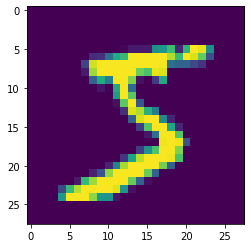

tf.Tensor([5], shape=(1,), dtype=int64)


In [22]:
# print(trn_graph)
data = list(trn_graph.take(1))[0]
print(data)
plt.imshow(np.reshape(np.array(tfgnn.graph_tensor_to_values(data[0])["node_sets"]["pixel"]["hidden_state"]), (28, 28)))
plt.show()
print(data[1])

In [8]:
model.fit(trn_graph, epochs=10)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'gnn/graph_update_7/node_set_update/simple_convolution/edge_set_update/GatherV2_1' defined at (most recent call last):
    File "/usr/local/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/local/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/local/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/usr/local/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/usr/local/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2833, in run_cell
      result = self._run_cell(
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2879, in _run_cell
      return runner(coro)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3280, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3340, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_50752/3319101676.py", line 1, in <cell line: 1>
      model.fit(trn_graph, epochs=10)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/tensorflow_gnn/graph/keras/layers/graph_update.py", line 218, in call
      update_fn(graph, node_set_name=node_set_name)))
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/tensorflow_gnn/graph/keras/layers/graph_update.py", line 388, in call
      input_from_edge_sets[edge_set_name] = input_fn(
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/tensorflow_gnn/graph/keras/layers/convolutions.py", line 58, in call
      messages = self._edge_set_update(graph, edge_set_name=edge_set_name)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/tensorflow_gnn/graph/keras/layers/graph_update.py", line 304, in call
      input_from_incident_nodes[node_tag] = ops.broadcast_node_to_edges(
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/tensorflow_gnn/graph/graph_tensor_ops.py", line 80, in broadcast_node_to_edges
      return tf.gather(node_value, adjacency[node_tag])
Node: 'gnn/graph_update_7/node_set_update/simple_convolution/edge_set_update/GatherV2_1'
indices[1488] = 760 is not in [0, 1)
	 [[{{node gnn/graph_update_7/node_set_update/simple_convolution/edge_set_update/GatherV2_1}}]] [Op:__inference_train_function_9197]